In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:
# Khởi tạo Spark Session
spark = SparkSession.builder.appName("StockForecasting").getOrCreate()
# Load dữ liệu
df = pd.read_csv("E:\Folder tai lieu\Lectures\scalable\Stock-Price-Forecasting-System-Using-Apache-Spark-main\data\processed\data.csv")
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df['Close'] = scaler.fit_transform(df[['Close']])

In [3]:
# Tạo mô hình Linear Regression với Spark
df_spark = spark.createDataFrame(df)
assembler = VectorAssembler(inputCols=['Open', 'High', 'Low', 'Volume'], outputCol='features')
data = assembler.transform(df_spark).select('features', 'Close')
lin_reg = LinearRegression(featuresCol='features', labelCol='Close')
model_lr = lin_reg.fit(data)

In [4]:
# Tạo mô hình ARIMA
arima_model = ARIMA(df['Close'], order=(5,1,0))
arima_result = arima_model.fit()


In [5]:
# Chuẩn bị dữ liệu cho LSTM
train_size = int(len(df) * 0.85)  # Tăng tỷ lệ dữ liệu huấn luyện
train, test = df['Close'].iloc[:train_size].values, df['Close'].iloc[train_size:].values
X_train, y_train, X_test, y_test = [], [], [], []
for i in range(10, len(train)):
    X_train.append(train[i-10:i])
    y_train.append(train[i])
for i in range(10, len(test)):
    X_test.append(test[i-10:i])
    y_test.append(test[i])
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Xây dựng mô hình LSTM
model_lstm = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # Tăng số lượng neurons
    LSTM(100),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)  # Tăng số epoch


c:\Users\Phu Bui\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0299
Epoch 2/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 3/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 4/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016
Epoch 5/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017
Epoch 6/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0018
Epoch 7/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019
Epoch 8/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 9/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014
Epoch 10/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 11/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 12/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 13/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011
Epoch 14/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0011
Epoch 15/30
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 16/30
53/53 ━

In [6]:
# Kết hợp dự đoán từ 3 mô hình
pred_lr = np.array(model_lr.transform(data).select('prediction').toPandas()).flatten()
pred_arima = np.array(arima_result.forecast(steps=len(df))).flatten()
pred_lstm = model_lstm.predict(X_test).flatten()

# Đảm bảo tất cả các mảng có cùng kích thước
min_len = min(len(pred_lr), len(pred_arima), len(pred_lstm), len(y_test))
pred_lr, pred_arima, pred_lstm, y_test = pred_lr[-min_len:], pred_arima[-min_len:], pred_lstm[-min_len:], y_test[-min_len:]

# Sử dụng trọng số khác nhau cho từng mô hình
hybrid_pred = (0.4 * pred_lr + 0.3 * pred_arima + 0.3 * pred_lstm)

# Giới hạn giá trị không vượt quá 1
hybrid_pred = np.clip(hybrid_pred, 0, 1)

# Đánh giá mô hình
mae = mean_absolute_error(y_test, hybrid_pred)
mse = mean_squared_error(y_test, hybrid_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, hybrid_pred)

print("Hybrid Model Evaluation:")
print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)

# In giá trị dự đoán
print("Hybrid Predictions:", hybrid_pred)
print("Actual Values:", y_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Hybrid Model Evaluation:
MAE: 0.11642247141052871
MSE: 0.01541801864492196
RMSE: 0.12416931442559373
R2 Score: 0.38407761176951327
Hybrid Predictions: [0.57651744 0.56769763 0.56508632 0.55076998 0.54058906 0.5362936
 0.54190665 0.5449805  0.55027935 0.54686983 0.54518536 0.54128641
 0.53626112 0.53973379 0.54730136 0.55355927 0.55139809 0.54581584
 0.54139281 0.5350123  0.54197688 0.54482201 0.54699144 0.55306383
 0.57052107 0.58326595 0.59511538 0.59974396 0.59607873 0.59448257
 0.6013737  0.61057583 0.61776415 0.64019062 0.65521568 0.65403774
 0.67397404 0.67914006 0.67648387 0.67396065 0.6566036  0.6466504
 0.6415657  0.64326414 0.65007802 0.64571585 0.63804232 0.64913186
 0.66009406 0.65668677 0.65506297 0.65974683 0.66707876 0.68331864
 0.68416983 0.68940477 0.70625741 0.7214993  0.7301515  0.72932224
 0.72094315 0.7128027  0.70820496 0.7181679  0.72021972 0.71780535
 0.72952525 0.72430567 0.73427027 0.7582805  0.77498973 0.7802403
 0.7757720

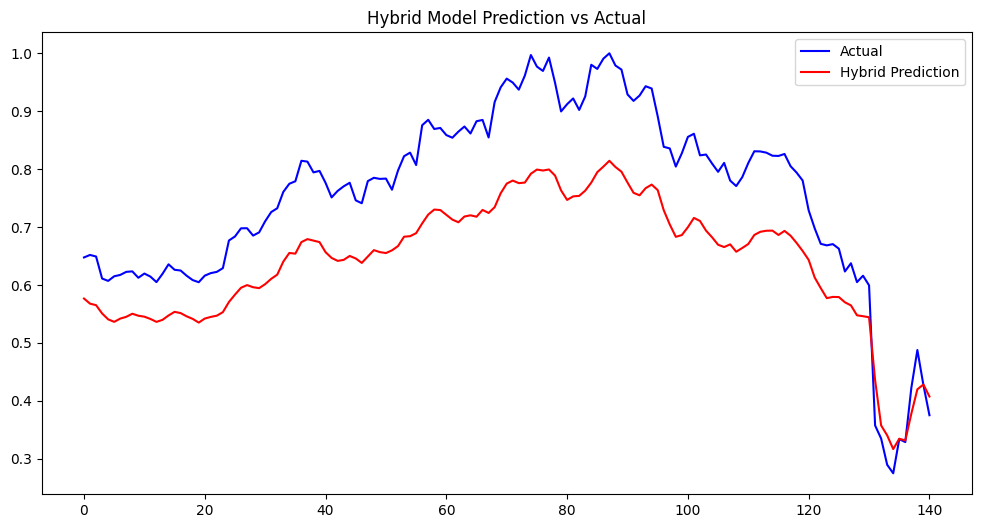

In [7]:
# Trực quan hóa kết quả
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual', color='blue')
plt.plot(range(len(y_test)), hybrid_pred, label='Hybrid Prediction', color='red')
plt.legend()
plt.title('Hybrid Model Prediction vs Actual')
plt.show()